# AI assignment 1 - The maze problem

Pouya Mohseni - 610398164

In [1]:
#import libraries 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import random
import copy

#define a function to copy the maze position and its attributes
#this is used when we want to have aopy of the initial position
#of the maze so that if we want to train again we do not need to
#set all the variables again

#training logs are blocked
class copy_maze():
    
    def __init__(self):
        pass
    
    def copy(self,maze):
        self.agent = copy.deepcopy(maze.agent)
        self.flags = copy.deepcopy(maze.flags)
        self.target = copy.deepcopy(maze.target)
        self.blocks = copy.deepcopy(maze.blocks)
        self.obstacles = copy.deepcopy(maze.obstacles)
        self.flag_num = copy.deepcopy(maze.flag_num) 
        self.env = [x[:] for x in maze.env]
        #self.env_agent = maze.env_agent 
        self.env_0 = copy.deepcopy(maze.env_0)
        self.env_1 =copy.deepcopy(maze.env_1)
        self.env_size = copy.deepcopy(maze.env_size) 
        self.env_lose = copy.deepcopy(maze.env_lose)
        self.visited = copy.deepcopy(maze.visited)
        self.lose = maze.lose
        self.win = maze.win
        self.train_curve = maze.train_curve
        
    def paste(self, maze):
        maze.agent = copy.deepcopy(self.agent)
        maze.flags = copy.deepcopy(self.flags)
        maze.target = copy.deepcopy(self.target)
        maze.blocks = copy.deepcopy(self.blocks)
        maze.obstacles = copy.deepcopy(self.obstacles)
        maze.flag_num = copy.deepcopy(self.flag_num)
        maze.env = copy.deepcopy(self.env)
        #maze.env_agent = self.env_agent 
        maze.env_0 = copy.deepcopy(self.env_0)
        maze.env_1 = copy.deepcopy(self.env_1)
        maze.env_size = copy.deepcopy(self.env_size)
        maze.env_lose = copy.deepcopy(self.env_lose)
        maze.visited = copy.deepcopy(self.visited)
        maze.lose = self.lose
        maze.win = self.win
        maze.train_curve = self.train_curve
      
    
#define maze in which tha maze and its corrisponding enviornment 
#is saved. Also training the agent is done using this class
class maze():
    agent: list #Agent's position [0,0]
    flags = [] #Flags' positions [[0,1],...]
    target: list #Target's positions [1,1]
    blocks = [] #blocks positions [[1,0],...]
    obstacles = [] #obsticales' positions [[2,1],...]
    flag_num: int #number of flags
    env: list #maze [[W,B,W,W],[W,F,T,O],...]
    env_agent: list #The env with agent and its path
    env_0: int #maze y size
    env_1: int #maze x size
    env_size: int #maze's size
    env_lose: int #lose points
    visited: list #2d, visited points is set 1
    train_curve: int #train steps in each epoch
    copy: copy_maze #maze attributes copy
    
    #lose_game = 0 #If it has lose the game
    #win_game = 0 #If it has win the game
    
    def __init__(self, env, agent, target):
        self.env = env
        self.agent = agent
        self.target = target
        self.train_curve = []
        
        for i in range(len(self.env)):
            for j in range(len(self.env[0])):
                if self.env[i][j]=="B": self.blocks.append([i,j])
                elif self.env[i][j]=="O": self.obstacles.append([i,j])
                elif self.env[i][j]=="F": self.flags.append([i,j])
                
        self.flag_num = len(self.flags)
        
        self.env_0 = len(self.env)
        self.env_1 = len(self.env[0])
        self.env_size = self.env_0*self.env_1

        self.visited = [[0 for _ in range(self.env_1)] for _ in range(self.env_0)]
        self.env_lose = -1
      
        #Copy the maze
        self.copy = copy_maze()
        self.copy.copy(self)
        
    def reload(self):
        #Reload the maze
        self.copy.paste(self)
    
    def show_env(self):
        #illustrate the enviornment
        plt.grid('on')
        self.set_env_agent()
        cmap = ListedColormap(["white", "yellow","red","black","gray",'green','blue'])
        plt.imshow([[{"W":0,"A":6,"T":2,"B":3,"V":4,"F":5,"O":1}.get(i) for i in item]  for item in self.env_agent],cmap=cmap, interpolation='nearest')

        plt.show()
    
    def print_env(self):
        #print the environment
        self.set_env_agent()
        print('#'*(len(self.env_agent)+2))
        for row in self.env_agent:
            for point in ['B']+row+['B']:
                if point=='A': print('A',end='')
                elif point=='F': print('F',end='')
                elif point=='T': print('T',end='')
                elif point=='B': print('#',end='')
                elif point=='O': print('O',end='')
                elif point=='V': print('.',end='')
                elif point=='W': print(' ',end='')
            print('')
        print('#'*(len(self.env_agent)+2))
        pass
    
    def set_env_agent(self):
        #put the agent in the environment in its corrisponding position
        self.env_agent = self.env
        
        self.env_agent[self.agent[0]][self.agent[1]]= "A"
        self.env_agent[self.target[0]][self.target[1]]= "T"
        
        for i in range(len(self.visited)):
            for j in range(len(self.visited[0])):
                if self.visited[i][j]==1: self.env_agent[i][j] = "V"
        
    
    def train(self,epochs,landa,alpha):
        #tain the model based on the number of epochs 
        #and the landa -> lambda and alpha values
        self.set_table(landa,alpha)
        
        
        for epoch in range(epochs):
            #save the number of training steps in a local variable
            self.train_curve.append(self.train_epoch())
    
    def train_epoch(self):
        #this is a function to have the first epoch passed
        #the agent takes actions in the environment till it
        #losses or wins the game.
        #all of the rewards are stored in the q-table
        steps = 0
        while not (self.lose() or self.win()):
            steps+=1
            self.take_a_step()
            
        #print(250*"-")
        self.eliminate_game()
        return steps
    
    def take_a_step(self):
        #through this function the agent makes an action
        #and the maze is changed based on the corrisponding
        #action
        
        action_set = {"L":0,"U":0,"R":0,"D":0}

        if self.agent[0] == 0: action_set.pop("U", None)
        if self.agent[0] == self.env_0-1: action_set.pop("D", None)
        if self.agent[1] == 0: action_set.pop("L", None)
        if self.agent[1] == self.env_1-1: action_set.pop("R",None)


        #policy and action
        for action in action_set:
            action_reward = (1 - self.qtable.alpha) * self.qtable.get_q(self.agent[0],self.agent[1],action) +  self.qtable.alpha *  (self.reward(action) + self.qtable.alpha * self.q_max(self.find_position(action)))
            self.qtable.set_q(self.agent[0],self.agent[1],action,action_reward)
            action_set.update({action:action_reward})
        
        #print the agent's actions and their rewards
        #print(action_set)
        
        #Move agent
        self.visited[self.agent[0]][self.agent[1]] += 1
        #max_reward = 0.8*max(action_set.values())
        #if max_reward>=0:action = random.choice([k for (k, v) in action_set.items() if v >= max_reward])
        #else:action = random.choice([k for (k, v) in action_set.items() if v <= max_reward])
        max_reward = max(action_set.values())
        random.choice([k for (k, v) in action_set.items() if v == max_reward])
        
        #print the choosed action among others
        #print(">->",action)
        
        #move the agent
        self.agent = self.find_position(action)
        
        
    def eliminate_game(self):
        #show the q-table after each iteration
        #maze.show_table(2)
        self.reload()

    def win(self):
        #check if the agent has won the game
        if len(self.flags)==0 and self.agent==self.target:
            return 1
        return 0
    
    def lose(self):
        #check if the agent has losen the game
        if self.q_max(self.agent)<=self.env_lose:
            return 1
        return 0
    
    def reward(self,action):
        #determine reward of each action
        #this function is fully introduced in the report
        """
        actions: [L: left,
                  U: up,
                  R: right,
                   D: down
        """

        new_agent = self.find_position(action)
            
        if self.env[new_agent[0]][new_agent[1]]=="B":
            return 10.0*self.env_lose
        elif self.env[new_agent[0]][new_agent[1]]=="F":
            self.achive_flag(new_agent)
            return 2*(self.env_size/self.flag_num)
        elif self.env[new_agent[0]][new_agent[1]]=="T" and len(self.flags)==0:
            return 1*self.env_size
        elif self.visited[new_agent[0]][new_agent[1]]>=2:
            return (-0.5*self.visited[new_agent[0]][new_agent[1]])/self.env_size
        elif self.visited[new_agent[0]][new_agent[1]]>=1:
            return 0.9/self.env_size
        elif self.env[new_agent[0]][new_agent[1]]=='O':
            #find position of the moved object:
            new_obj = self.new_position(action,new_agent)
            
            #cases in which object acts as a block
            
            #when the object goes out of the board
            if new_obj[0]<0 or new_obj[1]<0 or new_obj[0]>=env_0 or new_obj[1]>=env_1:
                return 10.0*self.env_lose
            
            #when the object cannot move because of a block 
            if self.env[new_obj[0]][new_obj[1]]=='B':
                return 10.0*self.env_lose
            
            #we will not be punishing the agent if the object goes on a flag or target;
            #because maybe the agent is trying to open a new way
            
            #now that we are sure that object moves to a valid position
            #we can determine blocks around the object's old position
            #and its new position to determine how we want to punish the agent
            score1 = self.score_block(new_agent)
            score2 = self.score_block(new_obj)
            
            #if the object is moved to a better position
            if score2>=score1:
                return (1.0+(score2-score1)/5)/self.env_size
            elif score2+1==score1:
                return (1.0+2(score2-score1)/5)/self.env_size
            elif score2+2==score1:
                return (1.0+4(score2-score1)/5)/self.env_size
            else:
                #punish hardly if new new position looks terrible
                return (-0.5*(score2-score1)/5)/self.env_size
        else:
            return 1.0/self.env_size
   

    def score(self,position):
        #this function scores based on the positions
        #souranding enviornment
        p=position
        ps=[[p[0]+1,p[1]],[p[0]-1,p[1]],[p[0],p[1]+1],[p[0],p[1]+1],[p[0]+1,p[1]+1],[p[0]-1,p[1]-1],[p[0]-1,p[1]+1],[p[0]+1,p[1]-1]]
        score = 0
        for p in ps:
            if p[0]>=self.env_0: score+=1
            elif p[0]<0: score+=1
            elif p[1]>=self.env_1: score+=1
            elif p[1]<0: score+=1
            elif self.env[p[0]][p[1]]=='B': score+=1
            elif self.env[p[0]][p[1]]=='O': score+=1
        
        return score
    
    def achive_flag(self,agent):
        self.env[agent[0]][agent[1]]="W"
        self.flags.remove([agent[0],agent[1]])
        
    def q_max(self,new_agent):
        all_q = []
        for action in ["L","U","R","D"]:
            all_q.append(self.qtable.get_q(new_agent[0],new_agent[1],action))
        return max(all_q)
                                                       
    def find_position(self,action,agent=None):
        #find the new position of the agent based on the action
        if agent==None:
            if   action=="L": return [self.agent[0],self.agent[1]-1]
            elif action=="U": return [self.agent[0]-1,self.agent[1]]
            elif action=="R": return [self.agent[0],self.agent[1]+1]
            elif action=="D": return [self.agent[0]+1,self.agent[1]]
        else:
            if   action=="L": return [agent[0],agent[1]-1]
            elif action=="U": return [agent[0]-1,agent[1]]
            elif action=="R": return [agent[0],agent[1]+1]
            elif action=="D": return [agent[0]+1,agent[1]]
            
    def set_table(self,landa,alpha):
        #set a q-table
        self.qtable = qtable(self.env_0,self.env_1,self.env_lose,landa,alpha)
    
    def show_table(self,mode=1):
        #show thw q-table
        if mode==1: return self.qtable.show_table()
        if mode==2: return self.qtable.show_table_reward()
    
    def show_graph(self):
        #show graph
        return self.qtable.make_graph()
    

<>:273: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:275: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:273: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
<>:275: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\lenovo\AppData\Roaming\Python\Python38\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\lenovo\AppData\Local\Temp\ipykernel_10044\2577462022.py:273: SyntaxWarning: 'int' object is not callable; perhaps you missed a comma?
  return (1.0+2(score2-score1)/5)/self.env_size
C:\User

In [2]:
#define a qtable to have the agent take action based on it and
#update it through its exploration
class qtable:
    env: list
    env_0: int
    env_1: int
    landa: int
    alpha: int
    move = {"L":0,"U":1,"R":2,"D":3}
    move_l = ["L","U","R","D"]
    def __init__(self,env_0,env_1,env_lose,landa,alpha):
        self.env_0 = env_0
        self.env_1 = env_1
        self.landa = landa
        self.alpha = alpha
        self.env = [[[0 for _ in range(4)] for _ in range(env_1)] for _ in range(env_0)]
        
        for i in range(self.env_0):
            for j in range(self.env_1):
                if i == 0: self.env[i][j][1] = 100*env_lose
                if i == self.env_0-1: self.env[i][j][3] = 100*env_lose
                if j == 0: self.env[i][j][0] = 100*env_lose
                if j == self.env_1-1: self.env[i][j][2] = 100*env_lose

    def set_q(self,y,x,a,reward):
        self.env[y][x][self.move.get(a)]=reward

    def get_q(self,y,x,a):
        if x<0 or y<0 or x>=self.env_0 or y>=self.env_1: return -9e9 
        return self.env[y][x][self.move.get(a)]
    
    def qet_q_action(self,y,x):
        return self,
    
    def show_table(self):
        for i in range(self.env_0):
            for j in range(self.env_1):
                print(self.move_l[self.env[i][j].index(max(self.env[i][j]))], end=" |")  
            print()
            
    def show_table_reward(self):
        for i in range(self.env_0):
            for j in range(self.env_1):
                print(self.move_l[self.env[i][j].index(max(self.env[i][j]))],", %.2f" %self.env[i][j][self.env[i][j].index(max(self.env[i][j]))], end=" |")  
            print()
            
    def make_graph(self):
        #construct the adjacency matrix
        vertics_names = []
        vertics_names_str = []
        adjacency_matrix = []
        for i in range(self.env_0):
            for j in range(self.env_1): vertics_names.append([i,j])
        for i in range(self.env_0):
            for j in range(self.env_1): vertics_names_str.append(str((i,j)))
        
        adjacency_matrix = [[0 for i in vertics_names] for j in vertics_names]
        for a,i in enumerate(vertics_names): 
            for b,j in enumerate(vertics_names):
                if i[0]==j[0]:
                    if i[1]+1==j[1]:
                        adjacency_matrix[a][b] = round(self.env[i[0]][i[1]][2],3)
                    elif i[1]-1==j[1]:
                        adjacency_matrix[a][b] = round(self.env[i[0]][i[1]][0],3)
                elif i[1]==j[1]:
                    if i[0]+1==j[0]:
                        adjacency_matrix[a][b] = round(self.env[i[0]][i[1]][3],3)
                    elif i[0]-1==j[0]:
                        adjacency_matrix[a][b] = round(self.env[i[0]][i[1]][1],3)      
        show_graph(np.array(adjacency_matrix), vertics_names_str)
        
    def show_graph(adjacency_matrix, vertices_names):
        #show the graph based on nx and its adjacency matrix
        num_vertices = adjacency_matrix.shape[0]
        G = nx.Graph()
        vertex_index = {vertex: i for i, vertex in enumerate(vertices_names)}
        for i in range(num_vertices):
            if sum(adjacency_matrix[i]) != 0:
                G.add_node(vertices_names[i])
        for i in range(num_vertices):
            for j in range(i, num_vertices):
                if adjacency_matrix[i][j] != 0 and adjacency_matrix[i][j]>=-1:
                    G.add_edge(vertices_names[i], vertices_names[j], weight=adjacency_matrix[i][j])
        edge_labels = {(i, j): d.get('weight') for i, j, d in G.edges(data=True)}
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

### A training example

In [3]:
maze =     maze([
                ["W","B","W","W","W","W","W","W","W","W"],
                ["W","W","W","F","W","B","W","W","W","W"],
                ["F","W","W","W","W","B","F","W","W","W"],
                ["B","B","W","B","B","W","B","W","W","W"],
                ["W","F","B","W","B","W","B","B","B","W"],
                ["W","W","B","W","B","W","W","W","W","W"],
                ["W","W","W","W","W","W","W","W","W","W"],
                ["W","F","W","W","W","W","B","B","B","B"],
                ["W","B","B","B","B","B","W","W","W","W"],
                ["W","W","W","W","W","W","W","B","F","W"]
                ],[0,0],[9,9])

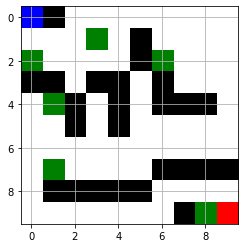

In [4]:
maze.show_env()

In [5]:
maze.print_env()

############
#A#        #
#   F #    #
#F    #F   #
### ## #   #
# F# # ### #
#  # #     #
#          #
# F    #####
# #####    #
#       #FT#
############


In [ ]:
maze.train(10,0.5,0.1)

In [ ]:
maze.show_table()

In [ ]:
maze.show_table(2)

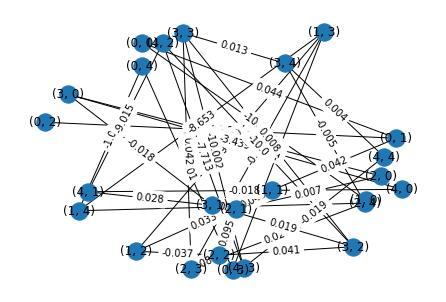

In [352]:
maze.show_graph()

In [ ]:
### A teraining comparison

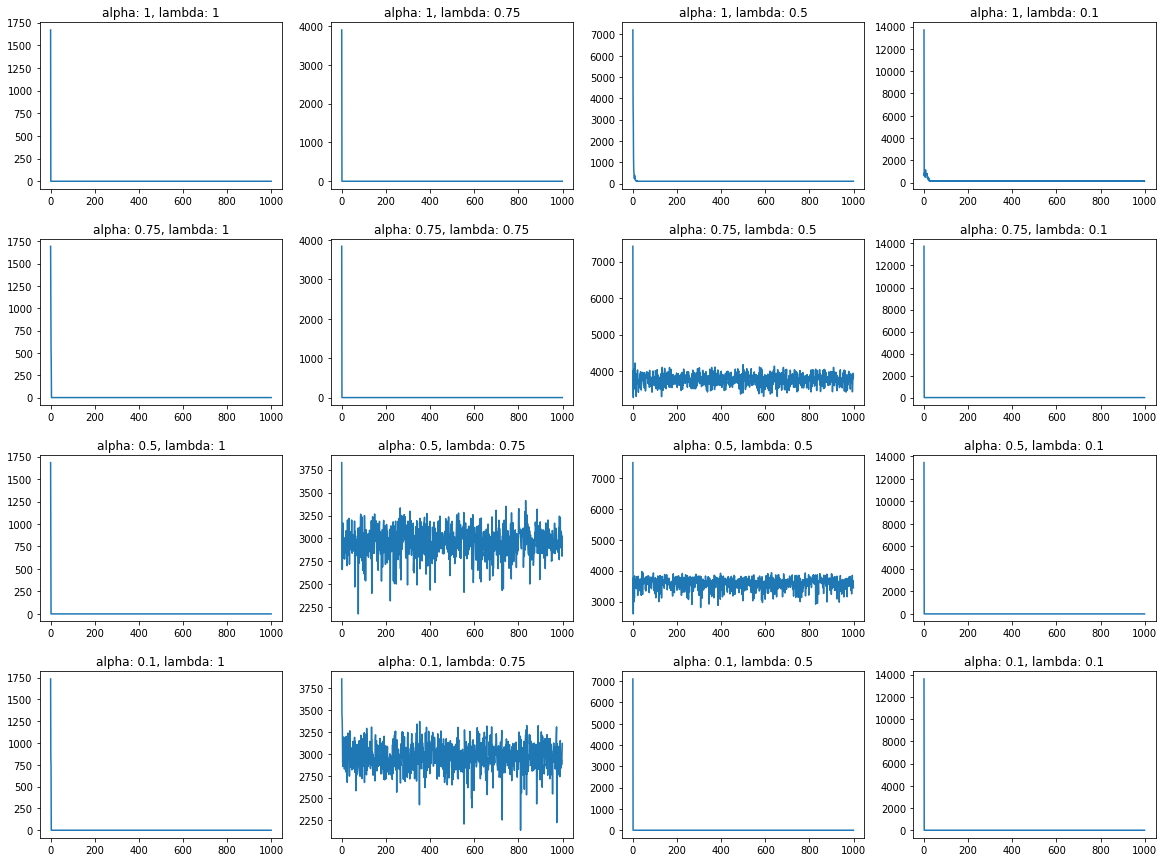

In [300]:
from matplotlib.pyplot import figure
n_epochs = 1000
fig = plt.figure(figsize=(20, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.2)
plot_num = 0
for alpha_ in [1,0.75,0.5,0.1]:
    for lambda_ in [1,0.75,0.5,0.1]:
        plot_num+=1
        tmaze = maze([
                ["W","B","W","W","W","W","W","W","W","W"],
                ["W","W","W","F","W","B","W","W","W","W"],
                ["F","W","W","W","W","B","F","W","W","W"],
                ["B","B","W","B","B","W","B","W","W","W"],
                ["W","F","B","W","B","F","B","B","B","W"],
                ["W","W","B","W","B","W","W","W","W","W"],
                ["W","W","W","W","W","W","W","W","W","W"],
                ["W","F","W","W","W","W","B","B","B","B"],
                ["W","B","B","B","B","B","W","W","W","W"],
                ["W","W","W","W","W","W","W","B","F","W"]
                ],[0,0],[9,9])
        
        tmaze.train(n_epochs,alpha_,lambda_)
        ax = fig.add_subplot(4, 4, plot_num)
        ax.set_title("alpha: "+str(alpha_)+", lambda: "+str(lambda_))
        ax.plot(tmaze.train_curve)
        
plt.show()